In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import csv
import os
cwd = os.getcwd()
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)


def settings_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter='=')
        output = dict()
        for row in reader:
            output[row[0]] = row[1]
    return output


def csv_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if zeroth_row == True:
                row.remove('')
                row = [float(value) for value in row]
                data = np.array(row)
                zeroth_row = False
            else:
                row.remove('')
                new_row = [float(value) for value in row]
                data = np.vstack([data, new_row])
    return data


def above(x, y, divider, theta, xc, yc):
    difference = y[:, np.newaxis] - divider(x, theta, xc, yc)
    above_yn = difference > 0
    return above_yn


def fidelity_calc(set1, set2, divider, theta, xc, yc):
    
    set1_above = np.sum(above(set1[0, :], set1[1, :], divider, theta, xc, yc), axis=0)
    set1_total = set1.shape[1]
    set1_above_fraction = 1.0 * set1_above / set1_total
  
    set2_above = np.sum(above(set2[0, :], set2[1, :], divider, theta, xc, yc), axis=0)
    set2_total = set2.shape[1]
    set2_above_fraction = 1.0 * set2_above / set2_total
       
    fidelity = 0.5 * (1 + np.abs(set1_above_fraction - set2_above_fraction))
    
    return fidelity


def initial_parameters_calc(set1, set2):
    set1_mean = np.mean(set1, axis=1)
    set2_mean = np.mean(set2, axis=1)
    midpoint = np.mean(np.array([set1_mean, set2_mean]), axis = 0)
    difference = set2_mean - set1_mean
    grad = difference[1] / difference[0]
    theta = np.arctan(-1 / grad)    
    return np.array([theta, midpoint[0], midpoint[1]]), difference


def divider(x, theta, xc, yc):
    y = (x[:, np.newaxis] - xc[np.newaxis, :]) * np.tan(theta[np.newaxis, :]) + yc[np.newaxis, :]
    return y


def best_guess(set1, set2, trials):
    fidelities = fidelity_calc(set1, set2, divider, trials[0, :], trials[1, :], trials[2, :])
    max_idx = np.argmax(fidelities)
    return trials[:, max_idx]

    
def new_trials(initial_trial, row, region, points):
    trials = np.zeros([3, points])
    trials[row, :] = np.linspace(-region/2, region/2, points)
    trials = trials + initial_trial[:, np.newaxis]
    return trials

In [ ]:
initial_trial, difference = initial_parameters_calc(set1, set2)
theta_range = np.pi
y_range = difference[1]
n_trials = 10
n_iterations = 3
refinement = 2

for idx in range(3):
    trials = new_trials(initial_trial, 0, theta_range, n_trials)
    initial_trial = best_guess(set1, set2, trials)
    trials = new_trials(initial_trial, 2, y_range, n_trials)
    initial_trial = best_guess(set1, set2, trials)
    theta_range = theta_range / refinement
    y_range = y_range / refinement

In [ ]:
initial_trial, difference = initial_parameters_calc(set1, set2)
theta_range = np.pi
y_range = difference[1]
n_trials = 10
n_iterations = 3
refinement = 2
trials = new_trials(initial_trial, 0, theta_range, n_trials)

In [ ]:
directory = './4MHz_down'
subdirectories = [x[0] for x in os.walk(directory)]
del subdirectories[0]

for sub in subdirectories:
    settings_path = sub + '/settings.cfg'
    settings = settings_load(settings_path)
    drive_frequency = float(settings['omega_d'])
    I_path = sub + '/ReaverageAlpha9.dat'
    Q_path = sub + '/ImaverageAlpha9.dat'
    I_dict = dict()
    Q_dict = dict()
    I_dict[drive_frequency] = csv_load(I_path)
    Q_dict[drive_frequency] = csv_load(Q_path)
    
I = I_dict[10.5046]
I_integrated = np.cumsum(I, axis=1)
Q = Q_dict[10.5046]
Q_integrated = np.cumsum(Q, axis=1)

In [ ]:
set1 = np.array([I_integrated[:, 1000], Q_integrated[:, 1000]])
set2 = np.array([I_integrated[:, 1500], Q_integrated[:, 1500]])

In [ ]:
initial_trial, difference = initial_parameters_calc(set1, set2)
theta = np.array([initial_trial[0]])
xc = np.array([initial_trial[1]])
yc = np.array([initial_trial[2]])
plt.scatter(set1[0, :], set1[1, :], color='k')
plt.scatter(set2[0, :], set2[1, :], color='r')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
x_linspace = np.linspace(xlim[0], xlim[1])
y_points = divider(x_linspace, theta, xc, yc)
plt.plot(x_linspace, y_points)
plt.xlim(xlim)
plt.ylim(ylim)
print fidelity_calc(set2, set1, divider, theta, xc, yc)

In [ ]:
initial_trial

In [ ]:
initial_trial, difference = initial_parameters_calc(set1, set2)
theta = np.array([initial_trial[0]])
xc = np.array([initial_trial[1]])
yc = np.array([initial_trial[2]])
plt.scatter(set1[0, :], set1[1, :], color='k')
plt.scatter(set2[0, :], set2[1, :], color='r')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
x_linspace = np.linspace(xlim[0], xlim[1])
y_points = divider(x_linspace, theta, xc, yc)
plt.plot(x_linspace, y_points)
plt.xlim(xlim)
plt.ylim(ylim)
print fidelity_calc(set2, set1, divider, theta, xc, yc)

initial_trial, difference = initial_parameters_calc(set1, set2)
theta_range = np.pi
y_range = np.linalg.norm(difference)
n_trials = 10
n_iterations = 5
refinement = 2

for idx in range(3):
    trials = new_trials(initial_trial, 0, theta_range, n_trials)
    initial_trial = best_guess(set1, set2, trials)
    trials = new_trials(initial_trial, 2, y_range, n_trials)
    initial_trial = best_guess(set1, set2, trials)
    theta_range = theta_range / refinement
    y_range = y_range / refinement
    
theta = np.array([initial_trial[0]])
xc = np.array([initial_trial[1]])
yc = np.array([initial_trial[2]])
x_linspace = np.linspace(xlim[0], xlim[1])
y_points = divider(x_linspace, theta, xc, yc)
plt.plot(x_linspace, y_points, color = 'g')

In [ ]:
np.absolute([1,2])

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import csv
import os
cwd = os.getcwd()
%matplotlib inline
pylab.rcParams['figure.figsize'] = (12, 8)


def settings_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile, delimiter='=')
        output = dict()
        for row in reader:
            output[row[0]] = row[1]
    return output


def csv_load(file_path):
    zeroth_row = True
    with open(file_path , 'rb') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if zeroth_row == True:
                row.remove('')
                row = [float(value) for value in row]
                data = np.array(row)
                zeroth_row = False
            else:
                row.remove('')
                new_row = [float(value) for value in row]
                data = np.vstack([data, new_row])
    return data


def above(x, y, trials):
    difference = y[:, :, np.newaxis] - divider(x, trials)
    above_yn = difference > 0
    return above_yn


def fidelity_calc(set1, set2, trials):
    
    set1_above = np.sum(above(set1[0, :, :], set1[1, :, :], trials), axis=0)
    set1_total = set1.shape[1]
    set1_above_fraction = 1.0 * set1_above / set1_total
  
    set2_above = np.sum(above(set2[0, :, :], set2[1, :, :], trials), axis=0)
    set2_total = set2.shape[1]
    set2_above_fraction = 1.0 * set2_above / set2_total
       
    fidelity = 0.5 * (1 + np.abs(set1_above_fraction - set2_above_fraction))
    
    return fidelity


def initial_parameters_calc(set1, set2):
    set1_mean = np.mean(set1, axis=1)
    set2_mean = np.mean(set2, axis=1)
    midpoint = np.mean(np.array([set1_mean, set2_mean]), axis = 0)
    difference = set2_mean - set1_mean
    grad = difference[1] / difference[0]
    theta = np.arctan(-1 / grad)    
    return np.array([theta, midpoint[0], midpoint[1]]), difference


def divider(x, trials):
    y = (x[:, :, np.newaxis] - trials[1, np.newaxis, :, :]) * np.tan(trials[0, np.newaxis, :, :]) + trials[2, np.newaxis, :, :]
    return y
#traj, trial
#now traj, trial, timeslice
#trials feed in as parameter, timeslice, trial
#out traj, timeslice, trial
#x in traj, timeslice


def best_guess(set1, set2, trials):
    fidelities = fidelity_calc(set1, set2, trials)
    max_idx = np.argmax(fidelities, axis=1)
    best = np.zeros([3, max_idx.shape[0]])
    for i, j in enumerate(max_idx):
        best[:, i] = trials[:, i, j]
    return best

    
def new_trials(initial_trial, param_idx, region, points):
    trials = np.zeros([3, region.shape[0], points])
    for idx, reg in enumerate(region):
        trials[param_idx, idx, :] = np.linspace(-reg/2, reg/2, points)
    trials = trials + initial_trial[:, :, np.newaxis]
    return trials


def optimize(set1, set2):

    initial_trials, differences = initial_parameters_calc(set1, set2)
    theta_range = np.pi * np.ones([set1.shape[2]])
    x_range = np.linalg.norm(differences, axis=0)
    y_range = np.linalg.norm(differences, axis=0)
    n_trials = 9
    n_iterations = 5
    refinement = 1.5
    best_trials = initial_trials
    
    for idx in range(n_iterations):
        trials = new_trials(best_trials, 0, theta_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        trials = new_trials(best_trials, 1, x_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        trials = new_trials(best_trials, 2, y_range, n_trials)
        best_trials = best_guess(set1, set2, trials)
        theta_range = theta_range / refinement
        x_range = x_range / refinement
        y_range = y_range / refinement
    
    best_fidelities = fidelity_calc(set1, set2, best_trials[:, :, np.newaxis])
    
    return best_fidelities, best_trials

In [ ]:
a = np.ones([3,3])
b = np.linalg.norm(a, axis=0)

In [ ]:
#optimizing
initial_trial, difference = initial_parameters_calc(set1, set2)
theta = initial_trial[0, :]
xc = initial_trial[1, :]
yc = initial_trial[2, :]

initial_trial, difference = initial_parameters_calc(set1, set2)
initial_fidelities = fidelity_calc(set1, set2, initial_trial[:, :, np.newaxis])
theta_range = np.pi * np.ones([set1.shape[2]])
x_range = np.linalg.norm(difference, axis=0)
y_range = np.linalg.norm(difference, axis=0)
n_trials = 9
n_iterations = 5
refinement = 1.5

for idx in range(3):
    trials = new_trials(initial_trial, 0, theta_range, n_trials)
    initial_trial = best_guess(set1, set2, trials)
    trials = new_trials(initial_trial, 1, x_range, n_trials)
    initial_trial = best_guess(set1, set2, trials)
    trials = new_trials(initial_trial, 2, y_range, n_trials)
    initial_trial = best_guess(set1, set2, trials)
    theta_range = theta_range / refinement
    x_range = x_range / refinement
    y_range = y_range / refinement
    
best_trial = initial_trial
best_fidelities = fidelity_calc(set1, set2, best_trial[:, :, np.newaxis])

0.8525


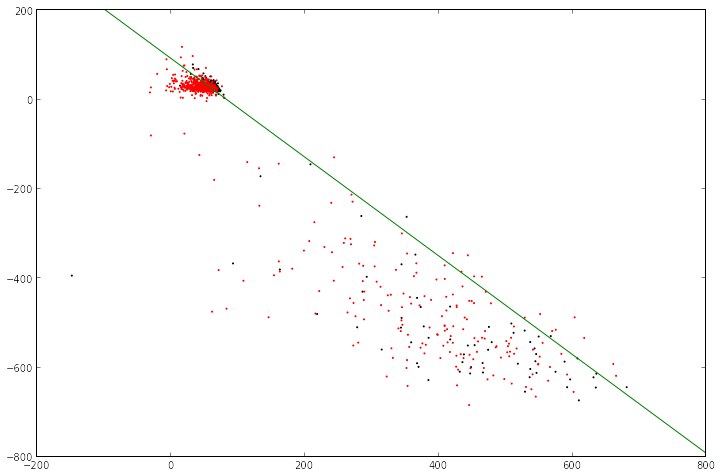

In [22]:
best_fidelities, best_trials = optimize(set1, set2)

#plotting
time = 1850
size = 1
plt.scatter(set1[0, :, time], set1[1, :, time], color='k', s=size)
plt.scatter(set2[0, :, time], set2[1, :, time], color='r', s=size)
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
x_linspace = np.linspace(xlim[0], xlim[1])
y_points = divider(x_linspace[:, np.newaxis], best_trials[:, :, np.newaxis])
plt.plot(x_linspace, y_points[:, time, 0], color='g')
plt.xlim(xlim)
plt.ylim(ylim)
print best_fidelities[time, 0]


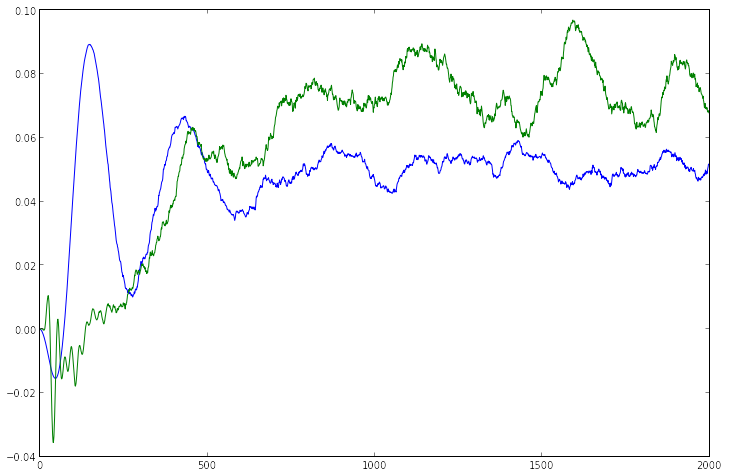

In [31]:
set1_mean = np.mean(set1, axis=1)
set2_mean = np.mean(set2, axis=1)
plt.plot(set1_mean[0,:])
plt.plot(set2_mean[0,:])

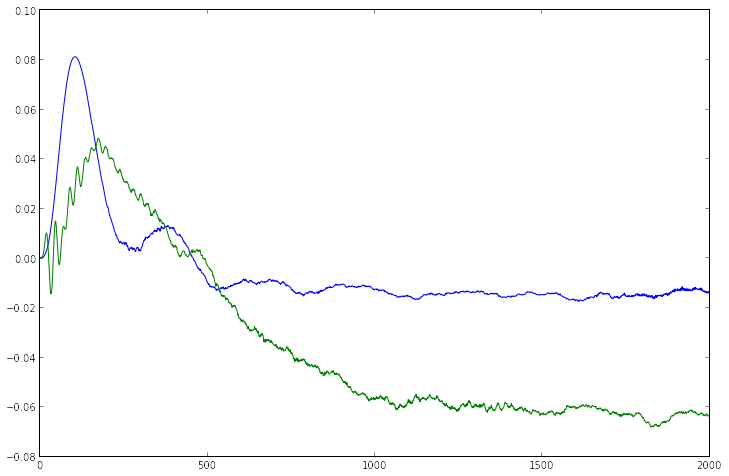

In [32]:
set1_mean = np.mean(set1, axis=1)
set2_mean = np.mean(set2, axis=1)
plt.plot(set1_mean[1,:])
plt.plot(set2_mean[1,:])

In [5]:
directory = './4MHz_down'
subdirectories = [x[0] for x in os.walk(directory)]
del subdirectories[0]

I_dict_d = dict()
Q_dict_d = dict()
for sub in subdirectories:
    settings_path = sub + '/settings.cfg'
    settings = settings_load(settings_path)
    drive_frequency = float(settings['omega_d'])
    I_path = sub + '/ReaverageAlpha9.dat'
    Q_path = sub + '/ImaverageAlpha9.dat'
    I_dict_d[drive_frequency] = csv_load(I_path)
    Q_dict_d[drive_frequency] = csv_load(Q_path)
    
directory = './4MHz_up'
subdirectories = [x[0] for x in os.walk(directory)]
del subdirectories[0]

I_dict_u = dict()
Q_dict_u = dict()
for sub in subdirectories:
    settings_path = sub + '/settings.cfg'
    settings = settings_load(settings_path)
    drive_frequency = float(settings['omega_d'])
    I_path = sub + '/ReaverageAlpha9.dat'
    Q_path = sub + '/ImaverageAlpha9.dat'
    I_dict_u[drive_frequency] = csv_load(I_path)
    Q_dict_u[drive_frequency] = csv_load(Q_path)

In [28]:
key = 10.5066
I_u = I_dict_u[key]
I_int_u = np.cumsum(I_u, axis=1)
Q_u = Q_dict_u[key]
Q_int_u = np.cumsum(Q_u, axis=1)
I_d = I_dict_d[key]
I_int_d = np.cumsum(I_d, axis=1)
Q_d = Q_dict_d[key]
Q_int_d = np.cumsum(Q_d, axis=1)

lower = 1
upper = 2000

set1 = np.array([I_d[:,lower:upper], Q_d[:,lower:upper]])
set2 = np.array([I_u[:,lower:upper], Q_u[:,lower:upper]])

set1_int = np.array([I_int_d[:,lower:upper], Q_int_d[:,lower:upper]])
set2_int = np.array([I_int_u[:,lower:upper], Q_int_u[:,lower:upper]])

In [34]:
type(I_dict_u.keys())

list

In [ ]:
#plotting
time = 1850
plt.scatter(set1[0, :, time], set1[1, :, time], color='k')
plt.scatter(set2[0, :, time], set2[1, :, time], color='r')
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
x_linspace = np.linspace(xlim[0], xlim[1])
initial_trial, difference = initial_parameters_calc(set1, set2)
y_points = divider(x_linspace[:, np.newaxis], initial_trial[:, :, np.newaxis])
plt.plot(x_linspace, y_points[:, time, 0])
plt.xlim(xlim)
plt.ylim(ylim)
print initial_fidelities[time, 0]

y_points = divider(x_linspace[:, np.newaxis], best_trial[:, :, np.newaxis])
plt.plot(x_linspace, y_points[:, time, 0], color='g')
plt.xlim(xlim)
plt.ylim(ylim)
print best_fidelities[time, 0]
